In [1]:
!pip install google-trans-new


In [2]:
import matplotlib.pyplot as plt
import re
import pandas as pd

from sklearn.model_selection import train_test_split

# Import Library
import random
import torch, torchtext
from torchtext import data 

# Manual Seed
SEED = 43
torch.manual_seed(SEED)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
import pandas as pd
df = pd.read_csv('apple_twitter_sentiment_dfe.csv')
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,#AAPL:The 10 best Steve Jobs emails ever...htt...,3
1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...,3
2,My cat only chews @apple cords. Such an #Apple...,3
3,I agree with @jimcramer that the #IndividualIn...,3
4,Nobody expects the Spanish Inquisition #AAPL,3


In [5]:
#number of records in the dataset
df.shape

(3886, 2)

In [6]:
df.sentiment.value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

In [7]:
#Remove the records which are not relevant
filtered_df = df[df['sentiment'] != 'not_relevant']
filtered_df.shape

(3804, 2)

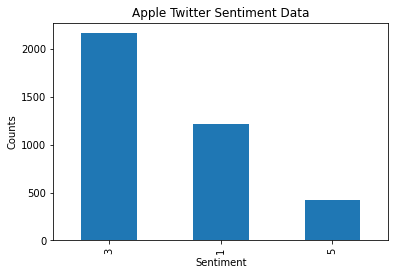

In [8]:
plt.title('Apple Twitter Sentiment Data')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
filtered_df['sentiment'].value_counts().plot(kind='bar')
plt.show()

##### preprocessing

1.   List item
2.   List item


removes @mentions, hashtag #, remove RT, removes hyperlinks

In [9]:
# Clean the tweets
def cleanText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'RT[\s]+', '', text)
  text = re.sub(r'https?:\/\/\S+', '', text)
  return text

filtered_df['text'] = filtered_df['text'].apply(cleanText)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [10]:
filtered_df.head()

,text,sentiment
0,AAPL:The 10 best Steve Jobs emails ever...,3
1,: Why AAPL Stock Had a Mini-Flash Crash Today ...,3
2,My cat only chews cords. Such an AppleSnob.,3
3,I agree with that the IndividualInvestor shou...,3
4,Nobody expects the Spanish Inquisition AAPL,3


### Part 1 - increase the training data with Backtranslate, Random Swap, insertion and deletion.

In [11]:
traindf, testdf = train_test_split(filtered_df, test_size=0.2, random_state=SEED)

In [12]:
import random
from random import shuffle
random.seed(1)

#stop words list
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
			'ours', 'ourselves', 'you', 'your', 'yours', 
			'yourself', 'yourselves', 'he', 'him', 'his', 
			'himself', 'she', 'her', 'hers', 'herself', 
			'it', 'its', 'itself', 'they', 'them', 'their', 
			'theirs', 'themselves', 'what', 'which', 'who', 
			'whom', 'this', 'that', 'these', 'those', 'am', 
			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
			'have', 'has', 'had', 'having', 'do', 'does', 'did',
			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
			'because', 'as', 'until', 'while', 'of', 'at', 
			'by', 'for', 'with', 'about', 'against', 'between',
			'into', 'through', 'during', 'before', 'after', 
			'above', 'below', 'to', 'from', 'up', 'down', 'in',
			'out', 'on', 'off', 'over', 'under', 'again', 
			'further', 'then', 'once', 'here', 'there', 'when', 
			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
			'very', 's', 't', 'can', 'will', 'just', 'don', 
			'should', 'now', '']

#cleaning up text
import re
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [13]:
from nltk.corpus import wordnet 

def synonym_replacement(words, n=3):
	new_words = words.copy()
	random_word_list = list(set([word for word in words if word not in stop_words]))
	random.shuffle(random_word_list)
	num_replaced = 0
	for random_word in random_word_list:
		synonyms = get_synonyms(random_word)
		if len(synonyms) >= 1:
			synonym = random.choice(list(synonyms))
			new_words = [synonym if word == random_word else word for word in new_words]
			#print("replaced", random_word, "with", synonym)
			num_replaced += 1
		if num_replaced >= n: #only replace up to n words
			break

	#this is stupid but we need it, trust me
	sentence = ' '.join(new_words)
	new_words = sentence.split(' ')

	return new_words

def get_synonyms(word):
	synonyms = set()
	for syn in wordnet.synsets(word): 
		for l in syn.lemmas(): 
			synonym = l.name().replace("_", " ").replace("-", " ").lower()
			synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
			synonyms.add(synonym) 
	if word in synonyms:
		synonyms.remove(word)
	return list(synonyms)

In [14]:
def replace_with_synonym(text):
  return synonym_replacement(text.split())

In [15]:

def random_deletion(sentence, p=0.2): 
  words = sentence.split()
  if len(words) == 1:
    return words
  remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
  if len(remaining) == 0: # if not left, sample a random word
    return ' '.join([random.choice(words)])
  else:
    return ' '.join(remaining)


In [16]:
def random_swap(sentence, n=2): 
    sentence = sentence.split()
    if len(sentence) > 4:

      length = range(len(sentence)-1) 
      #print(sentence, length)
      for _ in range(n):
          idx1, idx2 = random.sample(length, 2)
          sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
          #print(idx1, idx2, sentence)
      return ' '.join(sentence)
    return ' '.join(sentence)

In [17]:
import google_trans_new

from google_trans_new import google_translator

translator = google_translator()

In [18]:
def googletranslate(text):
  tempfr = translator.translate(text, lang_tgt='de')
  return translator.translate(tempfr, lang_src='de', lang_tgt='en')

In [19]:
def preaugment(text):
  rate = random.random()
  if rate < 0.4:
    text = replace_with_synonym(text)
  elif rate < 0.7:
    text = googletranslate(text)
  elif rate < 0.85:
    text = random_deletion(text)
  else:
    text = random_swap(text)
  return text

augmenting 60% of the training by using the proposed algorithm

In [20]:
tempdf = traindf.copy()
#apply augmentation on fractin of the dataset
tempdf = tempdf.sample(frac = 0.75, random_state=SEED)
tempdf['text'] = tempdf['text'].apply(preaugment)
augdf = pd.concat([traindf, tempdf], ignore_index=True)
print(traindf.shape, augdf.shape, testdf.shape)

(3043, 2) (5325, 2) (761, 2)


In [21]:
tempdf.head()

,text,sentiment
3361,"[:, protester, stage, DieIn, protests, in, lay...",3
968,: The iPhone 6 Plus will be huge in China this...,3
565,"[nobelium, sustain, debar, huh?]",3
1894,"[what, fear, me:, These, Co's, are, in, a, lay...",3
1157,Photo: Amazing customer service today store. U...,5


In [22]:
augdf.head()

,text,sentiment
0,iPhone 7 Release Date With Top 10 Most Needed ...,3
1,": Studio at 45,000 ft. One outlet, 4 compute...",3
2,Eddy Cue Speaks on Apple's DRM Policies in iPo...,3
3,Our app is coming soon! Still in production! ...,3
4,: whoknew Why isn't on Twitter? interestingf...,3


In [23]:
Tweet = data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
Label = data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)

In [24]:
fields = [('tweets', Tweet),('labels',Label)]

In [25]:
example = [data.Example.fromlist([augdf.text.iloc[i], augdf.sentiment.iloc[i]], fields) for i in range(augdf.shape[0])] 
AppleAugTrainDataset = data.Dataset(example, fields)

In [26]:
example = [data.Example.fromlist([traindf.text.iloc[i], traindf.sentiment.iloc[i]], fields) for i in range(traindf.shape[0])] 
AppleTrainDataset = data.Dataset(example, fields)

In [27]:
example = [data.Example.fromlist([testdf.text.iloc[i], testdf.sentiment.iloc[i]], fields) for i in range(testdf.shape[0])] 
AppleTestDataset = data.Dataset(example,fields)

In [28]:
(train, valid) = AppleTrainDataset, AppleTestDataset

In [29]:
len(train), len(valid)

(3043, 761)

In [30]:


Tweet.build_vocab(train)
Label.build_vocab(train)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

In [33]:

import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(Tweet.vocab.stoi, tokens)

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [35]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.3

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [36]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(6796, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=100, out_features=3, bias=True)
)
The model has 2,280,703 trainable parameters


In [37]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [38]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [40]:
N_EPOCHS = 100
best_valid_loss = float('inf')
acc_values = {'train' : [], 'valid' : []}
loss_values = {'train' : [], 'valid' : []}

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    acc_values['train'].append(train_acc)
    acc_values['valid'].append(valid_acc)
    loss_values['train'].append(train_loss)
    loss_values['valid'].append(valid_loss)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch : {epoch}\n\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Epoch : 0
	Train Loss: 0.948 | Train Acc: 60.15%
	 Val. Loss: 0.888 |  Val. Acc: 65.45% 

Epoch : 1
	Train Loss: 0.820 | Train Acc: 73.50%
	 Val. Loss: 0.842 |  Val. Acc: 70.93% 

Epoch : 2
	Train Loss: 0.771 | Train Acc: 78.19%
	 Val. Loss: 0.842 |  Val. Acc: 69.59% 

Epoch : 3
	Train Loss: 0.737 | Train Acc: 81.71%
	 Val. Loss: 0.837 |  Val. Acc: 70.93% 

Epoch : 4
	Train Loss: 0.713 | Train Acc: 84.02%
	 Val. Loss: 0.831 |  Val. Acc: 71.49% 

Epoch : 5
	Train Loss: 0.693 | Train Acc: 86.56%
	 Val. Loss: 0.841 |  Val. Acc: 70.28% 

Epoch : 6
	Train Loss: 0.678 | Train Acc: 87.89%
	 Val. Loss: 0.840 |  Val. Acc: 70.74% 

Epoch : 7
	Train Loss: 0.666 | Train Acc: 88.96%
	 Val. Loss: 0.853 |  Val. Acc: 68.85% 

Epoch : 8
	Train Loss: 0.672 | Train Acc: 88.64%
	 Val. Loss: 0.845 |  Val. Acc: 69.69% 

Epoch : 9
	Train Loss: 0.650 | Train Acc: 90.30%
	 Val. Loss: 0.844 |  Val. Acc: 70.34% 

Epoch : 10
	Train Loss: 0.644 | Train Acc: 90.92%
	 Val. Loss: 0.842 |  Val. Acc: 70.11% 

Epoch : 1

In [41]:
max(acc_values['train']), max(acc_values['valid'])

(0.9469401041666666, 0.7249479169646899)

In [159]:
(train, valid) = AppleAugTrainDataset, AppleTestDataset

In [160]:
len(train), len(valid)

(5325, 761)

In [161]:
Tweet.build_vocab(train)
Label.build_vocab(train)
print('Size of input vocab : ', len(Tweet.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Tweet.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  9363
Size of label vocab :  3
Top 10 words appreared repeatedly : [(' ', 2715), ('.', 2389), ('the', 2087), ('!', 1999), (':', 1727), (',', 1572), ('to', 1350), ('in', 1078), ('Apple', 1052), ('of', 1011)]
Labels :  defaultdict(<function _default_unk_index at 0x7faba9163950>, {'3': 0, '1': 1, '5': 2})


In [162]:
train_iterator, valid_iterator = data.BucketIterator.splits((train, valid), batch_size = 32, 
                                                            sort_key = lambda x: len(x.tweets),
                                                            sort_within_batch=True, device = device)

In [163]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [164]:
# Define hyperparameters
size_of_vocab = len(Tweet.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 3
num_layers = 2
dropout = 0.3

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [165]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [166]:
def random_swap(sentence, n=2): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

In [167]:

def random_deletion(words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    #print(remaining)
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining


In [168]:
def postaug(sentence):
  rate = random.random()
  if rate < 0.2:
    return random_swap(sentence)
  elif rate < 0.5:
    l = len(sentence)
    sentence = random_deletion(sentence)
    return torch.tensor(sentence + [1]*(l-len(sentence)))
  else:
    return sentence

In [169]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.tweets   
        tweet_list = [ postaug(t.cpu()) for t in tweet]
        
        tweet = torch.stack(tweet_list).long().to(device)
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [170]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            tweet, tweet_lengths = batch.tweets
            
            # convert to 1d tensor
            predictions = model(tweet, tweet_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [171]:
N_EPOCHS = 100
best_valid_loss = float('inf')
aug_acc_values = {'train' : [], 'valid' : []}
aug_loss_values = {'train' : [], 'valid' : []}

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    aug_acc_values['train'].append(train_acc)
    aug_acc_values['valid'].append(valid_acc)
    aug_loss_values['train'].append(train_loss)
    aug_loss_values['valid'].append(valid_loss)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'Epoch : {epoch}\n\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

Epoch : 0
	Train Loss: 0.939 | Train Acc: 60.91%
	 Val. Loss: 0.879 |  Val. Acc: 66.75% 

Epoch : 1
	Train Loss: 0.831 | Train Acc: 71.94%
	 Val. Loss: 0.855 |  Val. Acc: 69.35% 

Epoch : 2
	Train Loss: 0.785 | Train Acc: 76.59%
	 Val. Loss: 0.827 |  Val. Acc: 72.16% 

Epoch : 3
	Train Loss: 0.760 | Train Acc: 79.15%
	 Val. Loss: 0.831 |  Val. Acc: 71.51% 

Epoch : 4
	Train Loss: 0.735 | Train Acc: 81.79%
	 Val. Loss: 0.817 |  Val. Acc: 73.28% 

Epoch : 5
	Train Loss: 0.712 | Train Acc: 83.92%
	 Val. Loss: 0.816 |  Val. Acc: 73.05% 

Epoch : 6
	Train Loss: 0.692 | Train Acc: 86.10%
	 Val. Loss: 0.813 |  Val. Acc: 73.57% 

Epoch : 7
	Train Loss: 0.682 | Train Acc: 87.09%
	 Val. Loss: 0.817 |  Val. Acc: 72.53% 

Epoch : 8
	Train Loss: 0.669 | Train Acc: 88.45%
	 Val. Loss: 0.809 |  Val. Acc: 73.70% 

Epoch : 9
	Train Loss: 0.669 | Train Acc: 88.32%
	 Val. Loss: 0.812 |  Val. Acc: 73.28% 

Epoch : 10
	Train Loss: 0.659 | Train Acc: 89.34%
	 Val. Loss: 0.814 |  Val. Acc: 73.11% 

Epoch : 1

In [172]:
max(aug_acc_values['train']), max(aug_acc_values['valid'])

(0.9466691616766467, 0.7604687487085661)

In [173]:
#Saving the augmented accuracy,loss and non_augmented accuracy loss into a json file
btexperiment = {'NoAugacc' : acc_values,
                'NoAugloss' : loss_values,
                'Augacc' : aug_acc_values,
                'Augloss' : aug_loss_values}

import json

with open('proposedalgo.json', 'w') as f:
  json.dump(btexperiment, f, indent=2)

print('json file created successfully with accuracy and loss values.')

json file created successfully with accuracy and loss values.


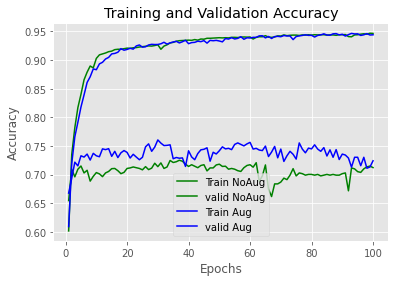

In [174]:
plt.style.use("ggplot")
epochs = range(1, 101)

plt.plot(epochs, acc_values['train'], 'g', label='Train NoAug')
plt.plot(epochs, acc_values['valid'], 'g', label='valid NoAug')
plt.plot(epochs, aug_acc_values['train'], 'b', label='Train Aug')
plt.plot(epochs, aug_acc_values['valid'], 'b', label='valid Aug')


plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig("accuracyproposed.jpg")
plt.show()

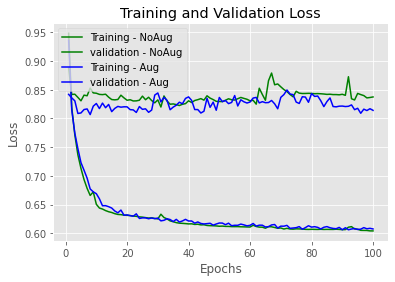

In [158]:
plt.style.use("ggplot")
epochs = range(1, 101)
plt.plot(epochs, loss_values['train'], 'g', label='Training - NoAug')
plt.plot(epochs, loss_values['valid'], 'g', label='validation - NoAug')
plt.plot(epochs, aug_loss_values['train'], 'b', label='Training - Aug')
plt.plot(epochs, aug_loss_values['valid'], 'b', label='validation - Aug')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('lossproposed.jpg')
plt.show()
